# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

**Основная задача:** нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания.

Для оценки качества моделей необходимо применить метрику RMSE.

*Описание данных:*
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

*Целевой признак:*
- Price — цена (евро)

## 1. Подготовка данных

### 1.1. Загрузка и изучение данных

Импортируем нужные библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
import warnings
from io import BytesIO
import requests
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import lightgbm as lgb
import seaborn as sns

In [2]:
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
pd.options.display.min_rows=30
pd.options.display.max_columns=50

Загрузим исходные данные, сохраним в `df`. Выведем основную информацию о датафрейме и первые 5 строк:

In [3]:
df = pd.read_csv('C:\\Users\\Public\\Documents\\datasets\\price_autos.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Посмотрим, за какой период нам предоставлены данные:

In [6]:
print('Даты создания анкет на авто: от ', df.DateCreated.min(), 'до ', df.DateCreated.max())

Даты создания анкет на авто: от  2014-03-10 00:00:00 до  2016-04-07 00:00:00


Данные содержат пропуски, подсчитаем их количество:

In [7]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Подсчитаем процент пропущенных данных:

In [8]:
(df.isna().sum()/len(df)*100).round(2)

DateCrawled           0.00
Price                 0.00
VehicleType          10.58
RegistrationYear      0.00
Gearbox               5.60
Power                 0.00
Model                 5.56
Kilometer             0.00
RegistrationMonth     0.00
FuelType              9.28
Brand                 0.00
NotRepaired          20.08
DateCreated           0.00
NumberOfPictures      0.00
PostalCode            0.00
LastSeen              0.00
dtype: float64

Проверим исходные данные на наличие явных дубликатов:

In [9]:
print("Число явных дубликатов в исходных данных:", df.duplicated().sum())

Число явных дубликатов в исходных данных: 4


Выведем описательную статистику по числовым столбцам:

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


Построим гистограмму распределения цен на авто:

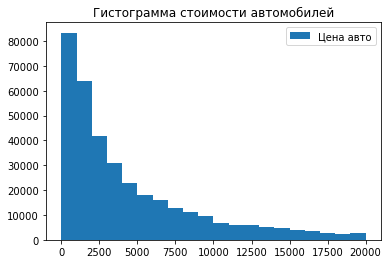

In [11]:
plt.hist(df['Price'], label='Цена авто', bins=20) 
plt.title('Гистограмма стоимости автомобилей')
plt.legend()
plt.show()

Стоит отметить, что несмотря на отсутствие пропусков в целевом признаке 'Price', распределение цен на авто начинается с нуля, что не может соответствовать действительности. Посмотрим, много ли нулевых цен в данных:

In [12]:
print('Число записей с нулевой стоимостью авто:', df[df.Price == 0].shape[0])
print(f'Процент записей с нулевой стоимостью авто: {round((df[df.Price == 0].shape[0]/len(df)*100),2)}%')

Число записей с нулевой стоимостью авто: 10772
Процент записей с нулевой стоимостью авто: 3.04%


Проверим линейную связь факторов на исходных данных, построим матрицу корреляций:

In [13]:
df.corr(method='spearman')

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.550988,0.512604,-0.314412,0.155247,NaN,0.078933
RegistrationYear,0.550988,1.000000,0.160182,-0.294567,0.052692,NaN,0.034934
Power,0.512604,0.160182,1.000000,0.084509,0.128826,NaN,0.081066
Kilometer,-0.314412,-0.294567,0.084509,1.000000,-0.011119,NaN,-0.017086
RegistrationMonth,0.155247,0.052692,0.128826,-0.011119,1.000000,NaN,0.014935
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.078933,0.034934,0.081066,-0.017086,0.014935,NaN,1.000000


*Выводы:*

Нам представлены данные о продажах 354369 автомобилей за 2 года: с марта 2014г по апрель 2016г.
Стоит отметить, что несмотря на отсутствие пропусков в целевом признаке 'Price', распределение цен на авто начинается с нуля, что не может соответствовать действительности - 3% записей с нулевой стоимостью авто.

Данные содержат пропуски: 
- 20% пропусков по столбцу о наличии прошлых ремонтов,
- 11% пропусков по типу кузова,
- 9% пропусков по типу топлива,
- 6% пропусков в указании модели транспортного средства,
- 6% пропусков в указании типа коробки передач.

Данные содержат артефакты:
- нулевые цены автомобилей,
- год регистрации с 1000г до 9999г, а по части анкет год регистрации авто превышает год размещения анкеты,
- мощность содержит нулевые значения и неадекватные максимальные значения (20 тыс. л.с.),
- месяц регистрации ТС содержит нулевые значения.

Линейная связь между ценой и годом регистрации, пробегом, мощностью средней или слабой тесноты, так как среди выборки представлены автомобили разных сегментов (и премиальные бренды, и массовые). Если строить матрицу корреляций в отдельности по каждому бренду или модели автомобиля, то связь будет более сильная. Характеристики линейной связи на общих данных:
- Прямая линейная связь средней силы наблюдается между ценой и годом регистрации авто (коэф. корреляции = 0.55) - это логично, так как новые автомобили, как правило, стоят дороже, чем авто бывшие в эксплуатации (если речь не о ретро-автомобилях). 
- Прямая линейная связь между ценой и мощностью (коэф. корреляции = 0.51) - чем мощнее автомобиль, тем выше цена. 
- Обратная линейная связь между ценой и пробегом (коэф. корреляции = -0.31) - чем меньше пробег, тем моложе и дороже стоит транспортное средство.

Между факторами связь слабая. Самый высокий коэф. корреляции среди факторов - между пробегом и годом регистрации, где коэффициент корреляции равен -0.29. Это интуитивно понятная зависимость: чем моложе автомобиль (чем больше год его регистрации), тем меньше пробег.

Данные требуют предобработки. Необходимо предпринять следующие действия:
- преобразовать названия столбцов,
- удалить дубликаты (в данных 4 явных дубликата, неявные будем искать),
- заполнить пропуски,
- преобразовать типы данных,
- удалить неинформативные данные (например, столбец с кол-вом фотографий, так как он имеет везде значение = 0)
- обработать артефакты в данных.

### 1.2. Предобработка данных

#### 1.2.1. Преобразование типов, работа с дубликатами

Преобразуем названия столбцов (приведем в "змеиный регистр"):

In [14]:
df.columns = df.columns.str.lower()
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [15]:
df.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen']

Преобразуем типы данных в столбцах с датами:

In [16]:
df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%Y-%m-%d %H:%M:%S')
df['date_created'] = pd.to_datetime(df['date_created'], format='%Y-%m-%d %H:%M:%S')
df['last_seen'] = pd.to_datetime(df['last_seen'], format='%Y-%m-%d %H:%M:%S')

Проверим, нет ли неявных дубликатов значений в текстовых столбцах:

In [17]:
for name in df.select_dtypes('object').columns:
    print(f'Список значений столбца {name}:')
    display(df[name].sort_values().unique())
    print('---------------')

Список значений столбца vehicle_type:


array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'wagon', nan], dtype=object)

---------------
Список значений столбца gearbox:


array(['auto', 'manual', nan], dtype=object)

---------------
Список значений столбца model:


array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

---------------
Список значений столбца fuel_type:


array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol',
       nan], dtype=object)

---------------
Список значений столбца brand:


array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

---------------
Список значений столбца not_repaired:


array(['no', 'yes', nan], dtype=object)

---------------


Неявных дубликатов в основных тестовых столбцах не обнаружено. Удалим явные дубликаты:

In [18]:
df = df.drop_duplicates()
df.shape

(354365, 16)

#### 1.2.2. Обработка пропусков

Займемся обработкой пропусков в столбцах. Нужно заполнить:
- 20% пропусков по столбцу о наличии прошлых ремонтов,
- 11% пропусков по типу кузова,
- 9% пропусков по типу топлива,
- 6% пропусков в указании модели транспортного средства,
- 6% пропусков в указании типа коробки передач.

Если значения в столбце о прошлых ремонтах "not_repaired" заполнялись экспертами сервис «Не бит, не крашен», то пропуски очевидно означают, что замечаний по машине не было найдено. Поэтому заполним данные пропуски значением 'no'.

In [19]:
df['not_repaired'] = df['not_repaired'].fillna('no')

Поле "vehicle_type" (тип кузова) имеет 11% пропусков. Но при этом в рамках даже одной модели ТС могут выпускаться авто с разными кузовами. Пока не ясно, насколько этот фактор влияет на финальную цену. Пропуски заполним самыми популярными типами кузова для каждой из моделей ТС. Для этого создадим словарь `dict_vehicle`, где ключами будут выступать модели ТС, а значения ключей - самый популярный тип кузова.

In [20]:
# группировка модель-кузов по убыванию популярности:
dict_vehicle = df.groupby(['model','vehicle_type'])['price'].count().sort_values(ascending=False).reset_index()

# удаляем дубликаты моделей:
dict_vehicle = dict_vehicle.drop_duplicates(subset=['model'])

# преобразуем данные в словарь:
dict_vehicle = dict_vehicle[['model','vehicle_type']].set_index('model').T.to_dict('index')['vehicle_type']
dict_vehicle

{'golf': 'sedan',
 'corsa': 'small',
 'polo': 'small',
 '3er': 'sedan',
 'passat': 'wagon',
 'other': 'sedan',
 'a4': 'wagon',
 'fiesta': 'small',
 '5er': 'sedan',
 'twingo': 'small',
 'c_klasse': 'sedan',
 'transporter': 'bus',
 'astra': 'sedan',
 'e_klasse': 'sedan',
 'a6': 'wagon',
 'clio': 'small',
 'a3': 'sedan',
 'fortwo': 'small',
 'focus': 'wagon',
 'touran': 'bus',
 '1er': 'sedan',
 'a_klasse': 'sedan',
 'punto': 'small',
 '2_reihe': 'small',
 'zafira': 'bus',
 'mondeo': 'wagon',
 'lupo': 'small',
 'vectra': 'sedan',
 'ka': 'small',
 'ibiza': 'small',
 'octavia': 'wagon',
 'micra': 'small',
 '3_reihe': 'sedan',
 'clk': 'coupe',
 'slk': 'convertible',
 'sharan': 'bus',
 'cooper': 'small',
 'leon': 'sedan',
 '1_reihe': 'small',
 'scenic': 'bus',
 '80': 'sedan',
 'galaxy': 'bus',
 '7er': 'sedan',
 'fabia': 'small',
 'mx_reihe': 'convertible',
 'm_klasse': 'suv',
 'yaris': 'small',
 'laguna': 'wagon',
 'megane': 'sedan',
 'meriva': 'bus',
 's_klasse': 'sedan',
 'x_reihe': 'suv',
 

Заполним пропуски по типу кузова данными из словаря `dict_vehicle`:

In [21]:
df['vehicle_type'] = df['vehicle_type'].fillna(df['model'].map(dict_vehicle))
print(f'Осталось пропусков по типу кузова: {df["vehicle_type"].isna().sum()} шт.')
print(f'Осталось пропусков по типу кузова: {(df["vehicle_type"].isna().sum()/len(df)*100).round(2)}%')

Осталось пропусков по типу кузова: 6828 шт.
Осталось пропусков по типу кузова: 1.93%


Аналогичным образом заполним пропуски в типе топлива: создадим словарь `dict_fuel`, где ключами будут выступать модели ТС, а значения ключей - самый популярный тип топлива:

In [22]:
dict_fuel = df.groupby(['model','fuel_type'])['price'].count().sort_values(ascending=False).reset_index()
dict_fuel = dict_fuel.drop_duplicates(subset=['model'])
# преобразуем данные в словарь:
dict_fuel = dict_fuel[['model','fuel_type']].set_index('model').T.to_dict('index')['fuel_type']
dict_fuel

{'golf': 'petrol',
 'other': 'petrol',
 '3er': 'petrol',
 'corsa': 'petrol',
 'polo': 'petrol',
 'astra': 'petrol',
 'passat': 'gasoline',
 'a4': 'gasoline',
 'fiesta': 'petrol',
 'c_klasse': 'petrol',
 'twingo': 'petrol',
 '2_reihe': 'petrol',
 'transporter': 'gasoline',
 '5er': 'gasoline',
 'a6': 'gasoline',
 'focus': 'petrol',
 'e_klasse': 'gasoline',
 'fortwo': 'petrol',
 'a3': 'petrol',
 'vectra': 'petrol',
 'clio': 'petrol',
 'punto': 'petrol',
 'a_klasse': 'petrol',
 'touran': 'gasoline',
 '3_reihe': 'petrol',
 'ka': 'petrol',
 'lupo': 'petrol',
 'ibiza': 'petrol',
 'megane': 'petrol',
 '1er': 'petrol',
 'mondeo': 'petrol',
 'cooper': 'petrol',
 'fabia': 'petrol',
 'micra': 'petrol',
 'clk': 'petrol',
 'zafira': 'petrol',
 '80': 'petrol',
 'x_reihe': 'gasoline',
 'slk': 'petrol',
 '1_reihe': 'petrol',
 'sharan': 'gasoline',
 'civic': 'petrol',
 'octavia': 'gasoline',
 'omega': 'petrol',
 'caddy': 'gasoline',
 'tt': 'petrol',
 'mx_reihe': 'petrol',
 'scenic': 'petrol',
 'yaris': 

Заполним пропуски по типу топлива данными из словаря `dict_fuel`:

In [23]:
df['fuel_type'] = df['fuel_type'].fillna(df['model'].map(dict_fuel))
print(f'Осталось пропусков по типу топлива: {df["fuel_type"].isna().sum()} шт.')
print(f'Осталось пропусков по типу топлива: {(df["fuel_type"].isna().sum()/len(df)*100).round(2)}%')

Осталось пропусков по типу топлива: 7163 шт.
Осталось пропусков по типу топлива: 2.02%


Заполним пропуски в типе коробки передач: создадим словарь `dict_gearbox`, где ключами будут выступать модели ТС, а значения ключей - самый популярный тип КПП:

In [24]:
dict_gearbox = df.groupby(['model','gearbox'])['price'].count().sort_values(ascending=False).reset_index()
dict_gearbox = dict_gearbox.drop_duplicates(subset=['model'])
# преобразуем данные в словарь:
dict_gearbox = dict_gearbox[['model','gearbox']].set_index('model').T.to_dict('index')['gearbox']
dict_gearbox

{'golf': 'manual',
 'other': 'manual',
 '3er': 'manual',
 'polo': 'manual',
 'corsa': 'manual',
 'astra': 'manual',
 'passat': 'manual',
 'a4': 'manual',
 'focus': 'manual',
 'fiesta': 'manual',
 'a3': 'manual',
 'e_klasse': 'auto',
 '2_reihe': 'manual',
 'c_klasse': 'manual',
 'twingo': 'manual',
 '5er': 'auto',
 'transporter': 'manual',
 'vectra': 'manual',
 'a6': 'auto',
 'clio': 'manual',
 'fortwo': 'auto',
 '3_reihe': 'manual',
 'punto': 'manual',
 'mondeo': 'manual',
 '1er': 'manual',
 'a_klasse': 'manual',
 'megane': 'manual',
 'zafira': 'manual',
 'ibiza': 'manual',
 'ka': 'manual',
 'touran': 'manual',
 'lupo': 'manual',
 'fabia': 'manual',
 'octavia': 'manual',
 'cooper': 'manual',
 'micra': 'manual',
 'caddy': 'manual',
 '80': 'manual',
 'clk': 'auto',
 'scenic': 'manual',
 'leon': 'manual',
 'civic': 'manual',
 '6_reihe': 'manual',
 '1_reihe': 'manual',
 'laguna': 'manual',
 'i_reihe': 'manual',
 'sharan': 'manual',
 'mx_reihe': 'manual',
 'x_reihe': 'auto',
 'meriva': 'man

Заполним пропуски по типу КПП данными из словаря `dict_gearbox`:

In [25]:
df['gearbox'] = df['gearbox'].fillna(df['model'].map(dict_gearbox))
print(f'Осталось пропусков по типу КПП: {df["gearbox"].isna().sum()} шт.')
print(f'Осталось пропусков по типу КПП: {(df["gearbox"].isna().sum()/len(df)*100).round(2)}%')

Осталось пропусков по типу КПП: 4131 шт.
Осталось пропусков по типу КПП: 1.17%


Заполним пропуски в наименовании моделей ТС похожим образом, по словарю. Для начала создадим столбец 'dict_model', содержащий сцепку основных параметров машин: марка, тип кузова. мощность. Эта сцепка и будет ключом по словарю `dict_model` с моделями машин.

In [26]:
df['dict_model'] = df['brand'] + df['vehicle_type'] + str(df['power'])

In [27]:
dict_model = df.groupby(['model','dict_model'])['price'].count().sort_values(ascending=False).reset_index()
dict_model = dict_model.drop_duplicates(subset=['dict_model'])
# преобразуем данные в словарь:
dict_model = dict_model[['model','dict_model']].set_index('dict_model').T.to_dict('index')['model']

Заполним пропуски:

In [28]:
df['model'] = df['model'].fillna(df['dict_model'].map(dict_model))
print(f'Осталось пропусков по модели авто: {df["model"].isna().sum()} шт.')
print(f'Осталось пропусков по модели авто: {(df["model"].isna().sum()/len(df)*100).round(2)}%')

Осталось пропусков по модели авто: 9163 шт.
Осталось пропусков по модели авто: 2.59%


Удалим ненужный столбец 'dict_model':

In [29]:
df = df.drop('dict_model', axis=1)
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,no,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,tt,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


Подсчитаем число строк, где данные пропущены сразу в нескольких столбцах:

In [30]:
print('Число строк с пропусками во всех 4-х столбцах, содержащих пропуски:', len(df[
    df.vehicle_type.isna()&
    df.gearbox.isna()&
    df.model.isna()&
    df.fuel_type.isna()]))

Число строк с пропусками во всех 4-х столбцах, содержащих пропуски: 2392


Перезапишем датафрейм, исключив строки, содержащие пропуски сразу в нескольких столбцах - они только будут мешать моделированию

In [31]:
df = df[~(df.vehicle_type.isna()&
    df.gearbox.isna()&
    df.model.isna()&
    df.fuel_type.isna())]

Подсчитаем, какой процент пропусков остался:

In [32]:
(df.isna().sum()/len(df)*100).round(2)

date_crawled          0.00
price                 0.00
vehicle_type          1.26
registration_year     0.00
gearbox               0.49
power                 0.00
model                 1.92
kilometer             0.00
registration_month    0.00
fuel_type             1.36
brand                 0.00
not_repaired          0.00
date_created          0.00
number_of_pictures    0.00
postal_code           0.00
last_seen             0.00
dtype: float64

Таким образом, мы существенно сократили доли пропусков. К сожалению, наименование модели автомобиля более неоткуда брать - строки с пропусками в этом столбце заменим на "other" ("прочие"):

In [33]:
df['model'] = df['model'].fillna('other')

Осталось совсем немного пропусков в столбцах "gearbox" и "fuel_type", "vehicle_type" - заполним их самыми популярными значениями внутри бренда:

In [34]:
dict_gearbox_brand = df.groupby(['brand','gearbox'])['price'].count().sort_values(ascending=False).reset_index()
dict_gearbox_brand = dict_gearbox_brand.drop_duplicates(subset=['brand'])
# преобразуем данные в словарь:
dict_gearbox_brand = dict_gearbox_brand[['brand','gearbox']].set_index('brand').T.to_dict('index')['gearbox']
df['gearbox'] = df['gearbox'].fillna(df['brand'].map(dict_gearbox_brand))

In [35]:
dict_fuel_brand = df.groupby(['brand','fuel_type'])['price'].count().sort_values(ascending=False).reset_index()
dict_fuel_brand = dict_fuel_brand.drop_duplicates(subset=['brand'])
# преобразуем данные в словарь:
dict_fuel_brand = dict_fuel_brand[['brand','fuel_type']].set_index('brand').T.to_dict('index')['fuel_type']
df['fuel_type'] = df['fuel_type'].fillna(df['brand'].map(dict_fuel_brand))

In [36]:
dict_vehicle_brand = df.groupby(['brand','vehicle_type'])['price'].count().sort_values(ascending=False).reset_index()
dict_vehicle_brand = dict_vehicle_brand.drop_duplicates(subset=['brand'])
# преобразуем данные в словарь:
dict_vehicle_brand = dict_vehicle_brand[['brand','vehicle_type']].set_index('brand').T.to_dict('index')['vehicle_type']
df['vehicle_type'] = df['vehicle_type'].fillna(df['brand'].map(dict_vehicle_brand))

In [37]:
print('Процент пропусков:')
(df.isna().sum()/len(df)*100)

Процент пропусков:


date_crawled          0.0
price                 0.0
vehicle_type          0.0
registration_year     0.0
gearbox               0.0
power                 0.0
model                 0.0
kilometer             0.0
registration_month    0.0
fuel_type             0.0
brand                 0.0
not_repaired          0.0
date_created          0.0
number_of_pictures    0.0
postal_code           0.0
last_seen             0.0
dtype: float64

Вывод: все пропуски обработаны

#### 1.2.3. Обработка артефактов

Данные содержат артефакты:
- нулевые цены автомобилей,
- год регистрации с 1000г до 9999г, а по части анкет год регистрации авто превышает год размещения анкеты,
- мощность содержит нулевые значения и неадекватные максимальные значения (20 тыс. л.с.),
- месяц регистрации ТС содержит нулевые значения.

Первым делом избавимся от артефактов в ценах авто: не может быть нулевой или близкой к нулю стоимости. Так как цена - это целевой признак, пропуски (нули) заполнять нельзя - мы просто удалим записи ниже 10 евро

In [38]:
print('Число строк, где цена менее 10 евро:', df[df.price<=10].shape[0])
print(f'Процент строк, где цена менее 10 евро: {round(df[df.price<=10].shape[0]/len(df)*100,1)}%')

Число строк, где цена менее 10 евро: 11190
Процент строк, где цена менее 10 евро: 3.2%


Перезапишем датафрейм, исключив цены до 10 евро:

In [39]:
df = df[df.price>10]
print('Осталось наблюдений:', df.shape[0])

Осталось наблюдений: 340783


Год регистрации ТС также содержит артефакты: объявления с годами до ХХ века есть смысл удалить. Также артефакты есть в максимальных значениях года регистрации. Данные в анкетах заполнялись не позже апреля 2016г, поэтому машин старше 2016г быть не должно.

In [40]:
print('Число строк, где год регистрации до 1900г или после 2016г:', 
      df[(df.registration_year<=1900) | (df.registration_year>2016)].shape[0])

Число строк, где год регистрации до 1900г или после 2016г: 13568


Заменим значения старше 2016г на 2016г, а значения до 1900г на 1900г:

In [41]:
def reg_year(year):
    if year < 1900:
        return 1900
    elif year > 2016:
        return 2016
    else:
        return year

In [42]:
df.registration_year = df.registration_year.apply(reg_year)

In [43]:
df.registration_year.describe()

count    340783.000000
mean       2003.149559
std           7.256733
min        1900.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2016.000000
Name: registration_year, dtype: float64

Мощность содержит нулевые значения и неадекватные максимальные значения. Даже гоночные болиды не имеют мощностей выше 1000 л.с. Поэтому данные свыше 800-1000 л.с. точно можно считать артефактами
Построим диаграмму размаха по мощности:

<AxesSubplot:>

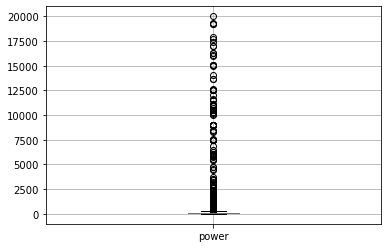

In [44]:
df.boxplot('power')

In [45]:
print('Число строк, где мощность более 800 л.с.:',df[df.power>800].shape[0])
print(f'Процент строк, где мощность более 800 л.с.:{round(df[df.power>800].shape[0]/len(df)*100,2)}%')

Число строк, где мощность более 800 л.с.: 309
Процент строк, где мощность более 800 л.с.:0.09%


Посмотрим на произвольные 5 строк с мощностью авто свыше 800 л.с.:

In [46]:
df[df.power>800].sample(5)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
348883,2016-03-13 11:51:57,7500,sedan,2011,manual,1548,scenic,90000,4,petrol,renault,no,2016-03-13,0,24568,2016-04-06 15:17:39
210610,2016-03-27 23:56:31,4500,convertible,2002,manual,1011,golf,100000,1,petrol,volkswagen,no,2016-03-27,0,90599,2016-04-06 08:46:50
254594,2016-03-11 13:55:09,3990,bus,2003,manual,1003,other,40000,12,petrol,citroen,no,2016-03-11,0,22525,2016-04-04 22:16:20
232901,2016-04-02 19:43:04,1300,small,1998,manual,6012,polo,150000,8,petrol,volkswagen,no,2016-04-02,0,70794,2016-04-02 19:43:04
32784,2016-03-22 14:58:27,9500,bus,1986,auto,1659,other,40000,12,petrol,chevrolet,no,2016-03-22,0,56564,2016-04-07 03:46:46


Очень похоже, что данные были загружены некорректно - потерялся разделитель между целой и десятичной частью числа. Скорректируем данные в мощности:

In [47]:
def power_new(power):
    if power>=800 and power<8000:
        return power/10
    elif power>=8000:
        return power/100
    else:
        return power

In [48]:
df['power'] = df['power'].apply(power_new)
print('Число строк, где мощность более 800 л.с.:',df[df.power>800].shape[0])

Число строк, где мощность более 800 л.с.: 0


Проверим, сколько нулевых мощностей в данных:

In [49]:
print('Число строк, где мощность нулевая:',df[df.power==0].shape[0])
print(f'Процент строк, где мощность нулевая.:{round(df[df.power==0].shape[0]/len(df)*100,2)}%')

Число строк, где мощность нулевая: 34510
Процент строк, где мощность нулевая.:10.13%


Нулевых мощностей довольно много. Возможно, по незнанию указывались нули или данные были выгружены с ошибками. Удалять такую существенную часть данных кажется неправильным. Попробуем обучать модели с этими признаками.

Среди артефактов мы выделяли также месяц регистрации ТС, который содержит нулевые значения. Так как это категориальный признак, и идей по замене нулей нет, сохраним данные в этом виде.

*Выводы:* предобработка данных произведена. Перейдем к процессу обучения моделей.

## 2. Обучение моделей

### 2.1. Подготовка данных для моделирования

Прежде чем задать `features` определимся с лишними столбцами:
- date_crawled - дата скачивания анкеты из базы
- last_seen - дата последней активности пользователя
- date_created - дата создания анкеты
- number_of_pictures - количество фотографий автомобиля (неинформативный столбец, так как он содержит везде одно и то же значение = 0).

Имеет смысл добавить столбец 'car_age' с возрастом автомобиля в годах: разница между датой создания анкеты и датой регистрации авто.

In [50]:
df['car_age'] = pd.DatetimeIndex(df['date_created']).year-df['registration_year']
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen,car_age
0,2016-03-24 11:52:17,480,sedan,1993,manual,0.0,golf,150000,0,petrol,volkswagen,no,2016-03-24,0,70435,2016-04-07 03:16:57,23
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190.0,tt,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50,5
2,2016-03-14 12:52:21,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,no,2016-03-14,0,90480,2016-04-05 12:47:46,12
3,2016-03-17 16:54:04,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17,15
4,2016-03-31 17:25:20,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21,8


Рассмотрим категориальный признак "postal_code":

In [51]:
print('Число уникальных индексов:', len(df.postal_code.unique()))

Число уникальных индексов: 8135


In [52]:
print('Минимальное значение индекса:', df.postal_code.min())
print('Максимальное значение индекса:', df.postal_code.max())

Минимальное значение индекса: 1067
Максимальное значение индекса: 99998


Вбив в поиске несколько произвольных индексов, было выявлено, что в таблице предоставлены почтовые индексы разных регионов Германии. Сгенерируем дополнительный фактор - регион внутри Германии. Диапазоны индексов для разных регионов Германии взяты из сети интернет:

In [53]:
spreadsheet_id = '1p2OgR6xuy34vus_3orzaBe1huVM92ehlzqyzba7SUlo'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
postal_code = pd.read_csv(BytesIO(r.content), sep=',')
postal_code

,postal_code_min,postal_code_max,region
0,1067,3041,Саксония (земля)
1,3042,3253,Бранденбург
2,3254,4889,Саксония (земля)
3,6108,6928,Саксония-Анхальт
4,7318,7989,Тюрингия
5,8056,9669,Саксония (земля)
6,10115,14199,Берлин
7,14200,17032,Бранденбург
8,17033,19417,Мекленбург - Передняя Померания
9,20038,21149,Гамбург


Для удобства создадим датафрейм с полным перечнем индексов из диапазонов и наименованием региона:

In [54]:
code=[]        # список индексов
region=[]      # список регионов
for i in range(len(postal_code)):
    for j in range(postal_code.loc[i,'postal_code_min'], postal_code.loc[i,'postal_code_max']+1):
        code.append(j)
        region.append(postal_code.loc[i,'region'])
        
df_postal_code = pd.DataFrame({'postal_code': code, 'region':region})
df_postal_code.sample(5)

,postal_code,region
15988,19173,Мекленбург - Передняя Померания
1010,2077,Саксония (земля)
36290,46230,Северный Рейн-Вестфалия
13,1080,Саксония (земля)
7526,10711,Берлин


Добавим регион в наш датафрейм:

In [55]:
df = df.merge(df_postal_code)
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen,car_age,region
0,2016-03-24 11:52:17,480,sedan,1993,manual,0.0,golf,150000,0,petrol,volkswagen,no,2016-03-24,0,70435,2016-04-07 03:16:57,23,Баден-Вюртемберг
1,2016-03-29 18:37:21,250,small,1999,manual,60.0,fiesta,150000,7,petrol,ford,yes,2016-03-29,0,70435,2016-03-29 18:37:21,17,Баден-Вюртемберг
2,2016-03-09 21:51:01,2500,small,2004,manual,54.0,panda,80000,4,petrol,fiat,no,2016-03-09,0,70435,2016-03-14 18:44:37,12,Баден-Вюртемберг
3,2016-03-17 11:47:25,1800,small,2001,manual,125.0,corsa,150000,10,petrol,opel,no,2016-03-17,0,70435,2016-04-06 11:46:09,15,Баден-Вюртемберг
4,2016-03-28 00:49:04,18300,suv,2007,auto,426.0,grand,100000,4,petrol,jeep,no,2016-03-27,0,70435,2016-04-06 09:15:19,9,Баден-Вюртемберг


Проверим, какие регионы есть в нашем датафрейме:

In [56]:
display(df.region.value_counts())
print('Число регионов в датафрейме:', len(df.region.unique()))

Северный Рейн-Вестфалия            61408
Баден-Вюртемберг                   37990
Гессен                             33718
Бавария                            24785
Рейнланд-Пфальц                    20876
Нижняя Саксония                    18743
Берлин                             14509
Шлезвиг-Гольштейн                  13131
Саксония (земля)                   10713
Бранденбург                         7403
Гамбург                             6624
Саксония-Анхальт                    6571
Саар                                6005
Тюрингия                            5302
Мекленбург - Передняя Померания     5053
Бремен (земля)                      4790
Name: region, dtype: int64

Число регионов в датафрейме: 16


Теперь мы можем не использовать столбец с указанием индекса, а использовать только группировку по регионам.

Закодируем категориальные переменные с помощью порядкового кодирования (OrdinalEncoder):

In [57]:
encoder = OrdinalEncoder()
df_categorial = df[['vehicle_type',              # категориальные переменные
                    'gearbox', 
                    'brand', 
                    'model', 
                    'fuel_type', 
                    'not_repaired', 
                    'region']]
df_ordinal = pd.DataFrame(encoder.fit_transform(df_categorial), columns = df_categorial.columns)
df_ordinal.head()

,vehicle_type,gearbox,brand,model,fuel_type,not_repaired,region
0,4.0,1.0,38.0,116.0,6.0,0.0,1.0
1,5.0,1.0,10.0,102.0,6.0,1.0,1.0
2,5.0,1.0,9.0,169.0,6.0,0.0,1.0
3,5.0,1.0,24.0,83.0,6.0,0.0,1.0
4,6.0,0.0,14.0,117.0,6.0,0.0,1.0


Соберем все необходимые данные для моделирования в датафрейм `df_analyse`, исключив все ненужные столбцы:

In [58]:
df_analyse = df.drop(
    ['vehicle_type', 'gearbox', 'brand', 'model', 'fuel_type', 'not_repaired', 'region',
    'date_crawled', 'last_seen', 'date_created', 'postal_code', 'number_of_pictures'], axis=1).join(df_ordinal)
df_analyse.head()

,price,registration_year,power,kilometer,registration_month,car_age,vehicle_type,gearbox,brand,model,fuel_type,not_repaired,region
0,480,1993,0.0,150000,0,23,4.0,1.0,38.0,116.0,6.0,0.0,1.0
1,250,1999,60.0,150000,7,17,5.0,1.0,10.0,102.0,6.0,1.0,1.0
2,2500,2004,54.0,80000,4,12,5.0,1.0,9.0,169.0,6.0,0.0,1.0
3,1800,2001,125.0,150000,10,15,5.0,1.0,24.0,83.0,6.0,0.0,1.0
4,18300,2007,426.0,100000,4,9,6.0,0.0,14.0,117.0,6.0,0.0,1.0


Зададим значения признаков и целевой переменной:

In [59]:
features = df_analyse.drop('price', axis=1)
target = df_analyse['price']

Разделим выборку на обучающую и тестовую:

In [60]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12)

In [61]:
features_train.head()

,registration_year,power,kilometer,registration_month,car_age,vehicle_type,gearbox,brand,model,fuel_type,not_repaired,region
229527,1998,751.2,150000,6,18,1.0,1.0,38.0,116.0,6.0,0.0,1.0
84513,2000,163.0,150000,12,16,1.0,1.0,20.0,208.0,6.0,0.0,9.0
86700,2008,116.0,100000,7,8,1.0,1.0,21.0,80.0,6.0,0.0,11.0
42625,2000,90.0,150000,10,16,5.0,1.0,24.0,83.0,6.0,0.0,1.0
119903,2010,125.0,60000,12,6,0.0,1.0,24.0,249.0,2.0,0.0,1.0


Проверим размеры выборок:

In [62]:
[x.shape for x in [features_train, features_test, target_train, target_test]]

[(208215, 12), (69406, 12), (208215,), (69406,)]

У количественных признаков разный масштаб. Поэтому стандартизируем их с помощью StandardScaler.

In [63]:
numeric = ['registration_year', 'power', 'kilometer', 'registration_month', 'car_age'] # список количественных признаков
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric]= scaler.transform(features_train[numeric])
features_test[numeric]= scaler.transform(features_test[numeric])

# первые 5 строк обучающей выборки после стандартизации
features_train.head()

,registration_year,power,kilometer,registration_month,car_age,vehicle_type,gearbox,brand,model,fuel_type,not_repaired,region
229527,-0.705787,10.179119,0.576756,0.050765,0.705796,1.0,1.0,38.0,116.0,6.0,0.0,1.0
84513,-0.430426,0.874753,0.576756,1.676372,0.430437,1.0,1.0,20.0,208.0,6.0,0.0,9.0
86700,0.671015,0.131289,-0.771228,0.321699,-0.671001,1.0,1.0,21.0,80.0,6.0,0.0,11.0
42625,-0.430426,-0.279988,0.576756,1.134503,0.430437,5.0,1.0,24.0,83.0,6.0,0.0,1.0
119903,0.946375,0.273655,-1.849616,1.676372,-0.946360,0.0,1.0,24.0,249.0,2.0,0.0,1.0


Напишем функцию для определения RMSE - критерия качества моделей:

In [64]:
def rmse(target, predict):
    rmse = mean_squared_error(target, predict)**0.5
    return rmse

rmse_scorer = make_scorer(rmse, greater_is_better=False)

*Вывод:* 
- переменные закодированы, 
- выборка разделена на обучающую и тестовую,
- критерий качества моделей RMSE введен. 

Можно переходить к моделированию

### 2.2. Линейная регрессия

Используем ОНЕ-кодирование для категориальных признаков в линейной регрессии:

In [65]:
features_train_lr = pd.get_dummies(features_train, drop_first=True,
                               columns = ['vehicle_type', 'gearbox', 'brand', 'model', 'fuel_type','not_repaired', 'region'])
features_train_lr.head()

,registration_year,power,kilometer,registration_month,car_age,vehicle_type_1.0,vehicle_type_2.0,vehicle_type_3.0,vehicle_type_4.0,vehicle_type_5.0,vehicle_type_6.0,vehicle_type_7.0,gearbox_1.0,brand_1.0,brand_2.0,brand_3.0,brand_4.0,brand_5.0,brand_6.0,brand_7.0,brand_8.0,brand_9.0,brand_10.0,brand_11.0,brand_12.0,...,model_247.0,model_248.0,model_249.0,fuel_type_1.0,fuel_type_2.0,fuel_type_3.0,fuel_type_4.0,fuel_type_5.0,fuel_type_6.0,not_repaired_1.0,region_1.0,region_2.0,region_3.0,region_4.0,region_5.0,region_6.0,region_7.0,region_8.0,region_9.0,region_10.0,region_11.0,region_12.0,region_13.0,region_14.0,region_15.0
229527,-0.705787,10.179119,0.576756,0.050765,0.705796,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
84513,-0.430426,0.874753,0.576756,1.676372,0.430437,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
86700,0.671015,0.131289,-0.771228,0.321699,-0.671001,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
42625,-0.430426,-0.279988,0.576756,1.134503,0.430437,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
119903,0.946375,0.273655,-1.849616,1.676372,-0.946360,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [66]:
features_test_lr = pd.get_dummies(features_test, drop_first=True,
                               columns = ['vehicle_type', 'gearbox', 'brand', 'model', 'fuel_type','not_repaired', 'region'])
features_test_lr.head()

,registration_year,power,kilometer,registration_month,car_age,vehicle_type_1.0,vehicle_type_2.0,vehicle_type_3.0,vehicle_type_4.0,vehicle_type_5.0,vehicle_type_6.0,vehicle_type_7.0,gearbox_1.0,brand_1.0,brand_2.0,brand_3.0,brand_4.0,brand_5.0,brand_6.0,brand_7.0,brand_8.0,brand_9.0,brand_10.0,brand_11.0,brand_12.0,...,model_247.0,model_248.0,model_249.0,fuel_type_1.0,fuel_type_2.0,fuel_type_3.0,fuel_type_4.0,fuel_type_5.0,fuel_type_6.0,not_repaired_1.0,region_1.0,region_2.0,region_3.0,region_4.0,region_5.0,region_6.0,region_7.0,region_8.0,region_9.0,region_10.0,region_11.0,region_12.0,region_13.0,region_14.0,region_15.0
173483,-2.082588,3.832788,-3.197600,-0.220170,2.082594,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
44686,-0.843467,-0.517264,0.576756,-0.762039,0.843476,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
255519,-0.705787,-0.517264,0.576756,-0.491105,0.705796,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
167883,0.671015,-0.042713,-0.771228,1.405438,-0.671001,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
77298,0.257974,-0.042713,0.576756,1.405438,-0.257962,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


Оставим в обучающей выборке только те столбцы, что есть в тестовой:

In [67]:
features_train_lr = features_train_lr[features_test_lr.columns]
features_train_lr.shape

(208215, 320)

Обучим модель линейной регрессии:

In [68]:
model_lr = LinearRegression()
model_lr.fit(features_train_lr, target_train)

LinearRegression()

Оценим качество модели линейной регрессии:

In [69]:
rmse_lr_train = (-1*cross_val_score(model_lr, features_train_lr, target_train, scoring=rmse_scorer, cv=3).mean()).round(0)
print('Качество на кросс-валидации:', rmse_lr_train)

rmse_lr = (rmse(target_test, model_lr.predict(features_test_lr))).round(0)
print('Качество на тестовой выборке:', rmse_lr)

Качество на кросс-валидации: 2783.0
Качество на тестовой выборке: 2788.0


Посмотрим на коэффициенты, которым научилась модель по всем показателям:

In [70]:
print('Смещение:', model_lr.intercept_.round(2))

Смещение: 5854.19


In [71]:
print('Коэффициенты модели:')
sorted(list(zip(features_train_lr.columns, model_lr.coef_)), 
       key=lambda x: abs(x[1]), reverse=True)

Коэффициенты модели:


[('car_age', -14248.529754425532),
 ('registration_year', -13143.861478760748),
 ('model_68.0', 7221.4154192444685),
 ('model_157.0', 7153.309393983389),
 ('model_130.0', 6948.796892268473),
 ('model_231.0', 6255.713951254286),
 ('model_30.0', 6121.850459971691),
 ('model_114.0', 6031.9646076040535),
 ('model_88.0', 5804.128305410068),
 ('model_18.0', 5715.410237215536),
 ('model_219.0', 5645.987963719042),
 ('model_201.0', -5522.292284906388),
 ('model_115.0', 5396.572656615882),
 ('model_26.0', 4885.345448725888),
 ('model_180.0', 4863.018087521479),
 ('model_179.0', 4809.638224537431),
 ('model_185.0', 4800.505167895916),
 ('brand_26.0', 4741.49844839509),
 ('model_240.0', 4725.680156144017),
 ('model_9.0', 4695.019548311896),
 ('model_246.0', 4501.357320879478),
 ('model_135.0', 4498.828175465324),
 ('model_39.0', 4448.227269891434),
 ('model_100.0', 4414.623643131416),
 ('model_207.0', 4231.365694780465),
 ('model_178.0', 4200.948619143872),
 ('model_199.0', 4134.844199943257),
 (

Наибольшие по модулю коэффициенты на возрасте и годе выпуска авто

Оценим скорость работы модели на тестовой выборке:

In [72]:
%%time
lr_predict = model_lr.predict(features_test_lr)

Wall time: 283 ms


### 2.3. Дерево решений в регрессии

Для начала построим модель дерева решений с дефолтными параметрами:

In [73]:
dt = DecisionTreeRegressor(random_state=0)

In [74]:
dt.fit(features_train, target_train)

DecisionTreeRegressor(random_state=0)

In [75]:
print('Качество на обучающей выборке:', 
     (rmse(target_train, dt.predict(features_train))).round(0))
print('Качество на тестовой выборке:', 
     (rmse(target_test, dt.predict(features_test))).round(0))

Качество на обучающей выборке: 243.0
Качество на тестовой выборке: 2189.0


Продемонстрируем важность характеристик:

In [76]:
dt_importances = pd.DataFrame({'Признак': features_train.columns, 
              'Важность признака':dt.feature_importances_}).sort_values(
    by='Важность признака', ascending=False).reset_index(drop=True)
dt_importances

,Признак,Важность признака
0,car_age,0.380597
1,power,0.280897
2,registration_year,0.090159
3,kilometer,0.054628
4,brand,0.039634
5,model,0.036418
6,vehicle_type,0.033052
7,registration_month,0.030922
8,region,0.027038
9,not_repaired,0.010731


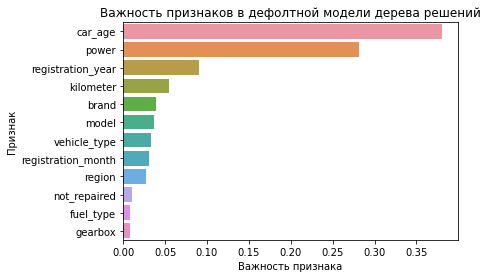

<Figure size 864x432 with 0 Axes>

In [77]:
sns.barplot(x=dt_importances['Важность признака'],
            y=dt_importances['Признак'])
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков в дефолтной модели дерева решений')
plt.figure(figsize=(12,6))
plt.show()

- Наиболее значимыми оказались: возраст авто (признак, который мы сгенерировали самостоятельно), мощность и год регистрации. 
- Наименее значимые: тип КПП, тип топлива и наличие ремонтов.
-----
Осуществим подбор параметров для дерева решений с помощью GridSearchCV. Были протестированы различные диапазоны для гиперпараметров. Ниже продемонстрирован подбор в диапазоне, который дал лучший результат. 

Зададим диапазон глубины дерева решений:

In [78]:
parametrs_dt = {'max_depth': range(10,21,2),
               'min_samples_split': range(2,11,2),
               'min_samples_leaf': range(5,10)}

Осуществим подбор гиперпараметров для модели дерева решений:

In [79]:
decision_tree = GridSearchCV(estimator=DecisionTreeRegressor(random_state=0), 
                             param_grid=parametrs_dt, 
                             scoring=rmse_scorer, cv=3)
decision_tree.fit(features_train, target_train)

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=0),
             param_grid={'max_depth': range(10, 21, 2),
                         'min_samples_leaf': range(5, 10),
                         'min_samples_split': range(2, 11, 2)},
             scoring=make_scorer(rmse, greater_is_better=False))

In [80]:
print('Оптимальная глубина дерева решений:', 
      decision_tree.best_params_.get('max_depth'))
print('Минимальное количество выборок, необходимое для разделения внутреннего узла:', 
      decision_tree.best_params_.get('min_samples_split'))
print('Минимальное количество выборок, необходимое для конечного узла:', 
      decision_tree.best_params_.get('min_samples_leaf'))

Оптимальная глубина дерева решений: 18
Минимальное количество выборок, необходимое для разделения внутреннего узла: 2
Минимальное количество выборок, необходимое для конечного узла: 9


Гиперпараметры подобраны. Оценим качество модели:

In [81]:
rmse_dt_train = (-1*decision_tree.best_score_).round(0)
print('Качество на кросс-валидации:', rmse_dt_train)

rmse_dt = (rmse(target_test, decision_tree.predict(features_test))).round(0)
print('Качество на тестовой выборке:', rmse_dt)

Качество на кросс-валидации: 1944.0
Качество на тестовой выборке: 1871.0


Продемонстрируем важность характеристик:

In [82]:
decision_tree_importances = pd.DataFrame({'Признак': features_train.columns, 
              'Важность признака':decision_tree.best_estimator_.feature_importances_}).sort_values(
    by='Важность признака', ascending=False).reset_index(drop=True)
decision_tree_importances

,Признак,Важность признака
0,car_age,0.429913
1,power,0.301861
2,registration_year,0.090463
3,kilometer,0.051910
4,brand,0.033577
5,vehicle_type,0.029898
6,model,0.025540
7,registration_month,0.009865
8,not_repaired,0.009113
9,region,0.006902


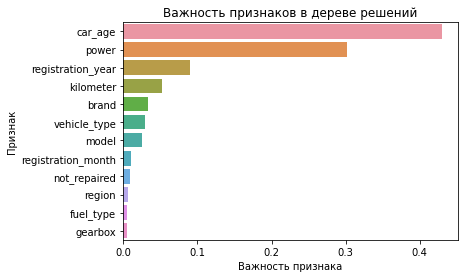

<Figure size 864x432 with 0 Axes>

In [83]:
sns.barplot(x=decision_tree_importances['Важность признака'],
            y=decision_tree_importances['Признак'])
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков в дереве решений')
plt.figure(figsize=(12,6))
plt.show()

- ТОП-3 наиболее значимых признаков: возраст авто (признак, который мы сгенерировали самостоятельно), мощность и год регистрации. 
- Наименее значимые: тип КПП, тип топлива и регион.

Оценим скорость работы модели на тестовой выборке:

In [84]:
%%time
dt_predict = decision_tree.predict(features_test)

Wall time: 45 ms


### 2.4. Случайный лес в регрессии

Для начала построим модель случайного леса с дефолтными параметрами:

In [85]:
rf = RandomForestRegressor(random_state=0, max_features='sqrt')

In [86]:
rf.fit(features_train, target_train)

RandomForestRegressor(max_features='sqrt', random_state=0)

In [87]:
print('Качество на обучающей выборке:', 
     (rmse(target_train, rf.predict(features_train))).round(0))
print('Качество на тестовой выборке:', 
     (rmse(target_test, rf.predict(features_test))).round(0))

Качество на обучающей выборке: 633.0
Качество на тестовой выборке: 1585.0


Продемонстрируем важность характеристик:

In [88]:
rf_importances = pd.DataFrame({'Признак': features_train.columns, 
              'Важность признака':rf.feature_importances_}).sort_values(
    by='Важность признака', ascending=False).reset_index(drop=True)
rf_importances

,Признак,Важность признака
0,power,0.234406
1,car_age,0.218503
2,registration_year,0.217230
3,kilometer,0.075437
4,brand,0.049097
5,model,0.040627
6,vehicle_type,0.037440
7,registration_month,0.035125
8,region,0.029284
9,fuel_type,0.028047


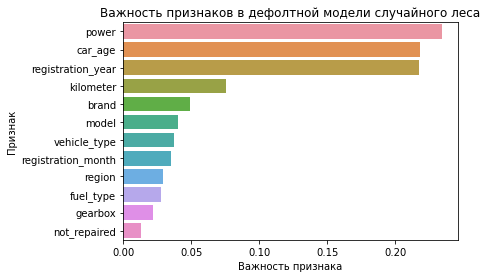

<Figure size 864x432 with 0 Axes>

In [89]:
sns.barplot(x=rf_importances['Важность признака'],
            y=rf_importances['Признак'])
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков в дефолтной модели случайного леса')
plt.figure(figsize=(12,6))
plt.show()

- ТОП-3 наиболее значимых признаков: мощность, возраст авто (признак, который мы сгенерировали самостоятельно) и год регистрации.
- Наименее значимые: тип КПП, тип топлива и наличие аварий.
----

Параметры будем подбирать с помощью GridSearchCV. Были протестированы различные диапазоны для гиперпараметров. Ниже продемонстрирован подбор в диапазоне, который дал лучший результат. Увеличение числа деревьев незначительно улучшает качество, но при этом время обучения существенно увеличивается.

Зададим диапазон глубины дерева решений и числа деревьев в лесе:

In [90]:
parametrs_rf = {'max_depth': range(18,28,3),
               'n_estimators': range(100,146,15)}

Осуществим подбор гиперпараметров для модели случайного леса:

In [91]:
random_forest = GridSearchCV(estimator=RandomForestRegressor(random_state=0, max_features='sqrt'), 
                             param_grid=parametrs_rf, 
                             scoring=rmse_scorer, cv=3, n_jobs=-1)

In [92]:
random_forest.fit(features_train, target_train)

GridSearchCV(cv=3,
             estimator=RandomForestRegressor(max_features='sqrt',
                                             random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': range(18, 28, 3),
                         'n_estimators': range(100, 146, 15)},
             scoring=make_scorer(rmse, greater_is_better=False))

In [93]:
print('Оптимальная глубина в модели случайного леса:',
      random_forest.best_params_.get('max_depth'))
print('Оптимальное число деревьев в модели случайного леса:',
      random_forest.best_params_.get('n_estimators'))

Оптимальная глубина в модели случайного леса: 24
Оптимальное число деревьев в модели случайного леса: 145


Гиперпараметры подобраны. Оценим качество модели:

In [94]:
rmse_rf_train = (-1*random_forest.best_score_).round(0)
print('Качество на кросс-валидации:', rmse_rf_train)

rmse_rf = (rmse(target_test, random_forest.predict(features_test))).round(0)
print('Качество на тестовой выборке:', rmse_rf)

Качество на кросс-валидации: 1647.0
Качество на тестовой выборке: 1578.0


Продемонстрируем важность характеристик:

In [95]:
random_forest_importances = pd.DataFrame({'Признак': features_train.columns, 
              'Важность признака': random_forest.best_estimator_.feature_importances_}).sort_values(
    by='Важность признака', ascending=False).reset_index(drop=True)
random_forest_importances

,Признак,Важность признака
0,power,0.231326
1,car_age,0.227098
2,registration_year,0.203578
3,kilometer,0.081135
4,brand,0.050522
5,model,0.041187
6,vehicle_type,0.039252
7,registration_month,0.033383
8,fuel_type,0.030281
9,region,0.027478


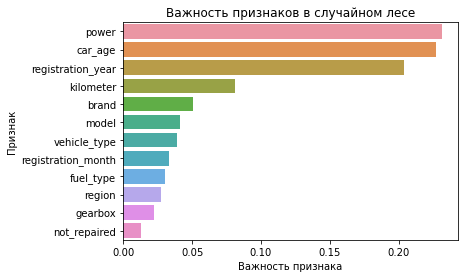

<Figure size 864x432 with 0 Axes>

In [96]:
sns.barplot(x=random_forest_importances['Важность признака'],
            y=random_forest_importances['Признак'])
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков в случайном лесе')
plt.figure(figsize=(12,6))
plt.show()

- ТОП-3 наиболее значимых признаков: мощность, возраст авто (признак, который мы сгенерировали самостоятельно) и год регистрации.
- Наименее значимые: тип КПП, тип топлива и наличие аварий.

Оценим скорость работы модели на тестовой выборке:

In [97]:
%%time
rf_predict = random_forest.predict(features_test)

Wall time: 6.06 s


### 2.5. Градиентный бустинг

Для начала построим модель бистинга с дефолтными параметрами:

In [99]:
lgbm_def = lgb.LGBMRegressor(objective="RMSE", random_state=0)
categorical_feature = ['vehicle_type', 'gearbox', 'brand', 'model', 'fuel_type',
       'not_repaired', 'region']      # список категориальных признаков

In [100]:
lgbm_def.fit(features_train, target_train, categorical_feature=categorical_feature)

LGBMRegressor(objective='RMSE', random_state=0)

In [101]:
print('Качество на обучающей выборке:', 
     (rmse(target_train, lgbm_def.predict(features_train))).round(0))
print('Качество на тестовой выборке:', 
     (rmse(target_test, lgbm_def.predict(features_test))).round(0))

Качество на обучающей выборке: 1631.0
Качество на тестовой выборке: 1693.0


Продемонстрируем важность характеристик в дефолтной модели:

In [102]:
lgbm_def_importances = pd.DataFrame({'Признак': features_train.columns, 
              'Важность признака':lgbm_def.feature_importances_}).sort_values(
    by='Важность признака', ascending=False).reset_index(drop=True)
lgbm_def_importances

,Признак,Важность признака
0,model,792
1,registration_year,660
2,power,515
3,kilometer,258
4,brand,243
5,vehicle_type,128
6,region,109
7,not_repaired,79
8,registration_month,71
9,car_age,54


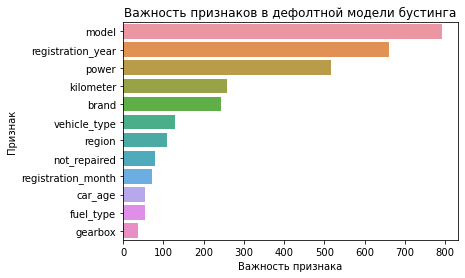

<Figure size 864x432 with 0 Axes>

In [106]:
sns.barplot(x=lgbm_def_importances['Важность признака'],
            y=lgbm_def_importances['Признак'])
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков в дефолтной модели бустинга')
plt.figure(figsize=(12,6))
plt.show()

- ТОП-3 наиболее значимых признаков: модель автомобиля, год регистрации и мощность.
- Наименее значимые: тип КПП, тип топлива и возраст авто.
------

Параметры будем подбирать с помощью GridSearchCV.  Были протестированы различные диапазоны для гиперпараметров. Ниже продемонстрирован подбор в диапазоне, который дал лучший результат.

Зададим диапазон глубины дерева решений и числа деревьев:

In [135]:
parametrs_lgbm = {'n_estimators': range(900,1101,50),
                 'num_leaves': range(50,71,10)}

Осуществим подбор гиперпараметров для модели градиентного бустинга:

In [136]:
lgbm = GridSearchCV(estimator=lgb.LGBMRegressor(objective="RMSE", random_state=0), 
                             param_grid=parametrs_lgbm, 
                             scoring=rmse_scorer, cv=3, n_jobs=-1)

In [137]:
lgbm.fit(features_train, target_train, categorical_feature=categorical_feature)

GridSearchCV(cv=3, estimator=LGBMRegressor(objective='RMSE', random_state=0),
             n_jobs=-1,
             param_grid={'n_estimators': range(900, 1101, 50),
                         'num_leaves': range(50, 71, 10)},
             scoring=make_scorer(rmse, greater_is_better=False))

In [138]:
print('Оптимальное число деревьев в модели бустинга:',
      lgbm.best_params_.get('n_estimators'))
print('Оптимальное число листьев на дереве в модели бустинга:',
      lgbm.best_params_.get('num_leaves'))

Оптимальное число деревьев в модели бустинга: 1100
Оптимальное число листьев на дереве в модели бустинга: 70


Гиперпараметры подобраны. Оценим качество модели:

In [139]:
rmse_lgbm_train = (-1*lgbm.best_score_).round(0)
print('Качество на кросс-валидации:', rmse_lgbm_train)

rmse_lgbm = (rmse(target_test, lgbm.predict(features_test))).round(0)
print('Качество на тестовой выборке:', rmse_lgbm)

Качество на кросс-валидации: 1609.0
Качество на тестовой выборке: 1567.0


Продемонстрируем важность характеристик:

In [142]:
lgbm_importances = pd.DataFrame({'Признак': features_train.columns, 
              'Важность признака':lgbm.best_estimator_.feature_importances_}).sort_values(
    by='Важность признака', ascending=False).reset_index(drop=True)
lgbm_importances

,Признак,Важность признака
0,power,18183
1,registration_year,17773
2,registration_month,11747
3,kilometer,7976
4,model,6963
5,region,5193
6,brand,2640
7,vehicle_type,2057
8,gearbox,1963
9,not_repaired,663


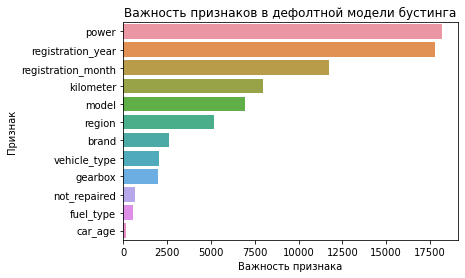

<Figure size 864x432 with 0 Axes>

In [143]:
sns.barplot(x=lgbm_importances['Важность признака'],
            y=lgbm_importances['Признак'])
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков в дефолтной модели бустинга')
plt.figure(figsize=(12,6))
plt.show()

- ТОП-3 наиболее значимых признаков: месяц регистрации, год регистрации и мощность.
- Наименее значимые: возраст, тип топлива и наличие аварий.

Оценим скорость работы модели на тестовой выборке:

In [144]:
%%time
lgbm_predict = lgbm.predict(features_test)

Wall time: 5.28 s


### 2.6. Константная модель

Построим и обучим константную модель, которая всегда будет предсказывать медианное значение цены автомобиля:

In [145]:
model_dr = DummyRegressor(strategy='median')

In [146]:
model_dr.fit(features_train, target_train)

DummyRegressor(strategy='median')

Оценим качество модели:

In [147]:
rmse_dr_train = (rmse(target_train, model_dr.predict(features_train))).round(0)
print('Качество на обучающей выборке:', rmse_dr_train)

rmse_dr = (rmse(target_test, model_dr.predict(features_test))).round(0)
print('Качество на тестовой выборке:', rmse_dr)

Качество на обучающей выборке: 4776.0
Качество на тестовой выборке: 4784.0


Оценим скорость работы модели на тестовой выборке:

In [148]:
%%time
dr_predict = model_dr.predict(features_test)

Wall time: 1 ms


## 3. Анализ моделей

Для анализа моделей добавим еще один показатель - величину средней абсолютной ошибки (Mean Absolute Error). Загрузим ее из библиотеки sklearn.metrics:

In [149]:
from sklearn.metrics import mean_absolute_error

In [150]:
mae_lr = (mean_absolute_error(target_test, lr_predict)).round(0)
mae_dt = (mean_absolute_error(target_test, dt_predict)).round(0)
mae_rf = (mean_absolute_error(target_test, rf_predict)).round(0)
mae_lgbm = (mean_absolute_error(target_test, lgbm_predict)).round(0)
mae_dr = (mean_absolute_error(target_test, dr_predict)).round(0)

Соберем все полученные значения RMSE, МАЕ и времени работы моделей в датафрейм:

In [151]:
models = pd.DataFrame({'Model': ['Линейная регрессия', "Дерево решений",
                                 "Случайный лес", "Градиентный бустинг", 'Константная модель'],
                    "RMSE_train": [rmse_lr_train, rmse_dt_train, rmse_rf_train, rmse_lgbm_train, rmse_dr_train],
                    "RMSE_test":[rmse_lr, rmse_dt, rmse_rf, rmse_lgbm, rmse_dr],
                      "Wall time": ['283 ms', '45 ms', '6.06 s', '5.28 s', '1 ms'],
                      "MAE_test":[mae_lr, mae_dt, mae_rf, mae_lgbm, mae_dr]})
models

,Model,RMSE_train,RMSE_test,Wall time,MAE_test
0,Линейная регрессия,2783.0,2788.0,283 ms,1968.0
1,Дерево решений,1944.0,1871.0,45 ms,1139.0
2,Случайный лес,1647.0,1578.0,6.06 s,946.0
3,Градиентный бустинг,1609.0,1567.0,5.28 s,963.0
4,Константная модель,4776.0,4784.0,1 ms,3242.0


Таким образом, лучшее качество по параметру RMSE показала модель бустинга. Модель случайного леса показала похожее качество. Обе модели существенно лучше константной по показателям RMSE, МАЕ.

Визуализируем на графике 50 случайных автомобилей из тестовой выборки: отобразим факт и предсказания модели бустинга:

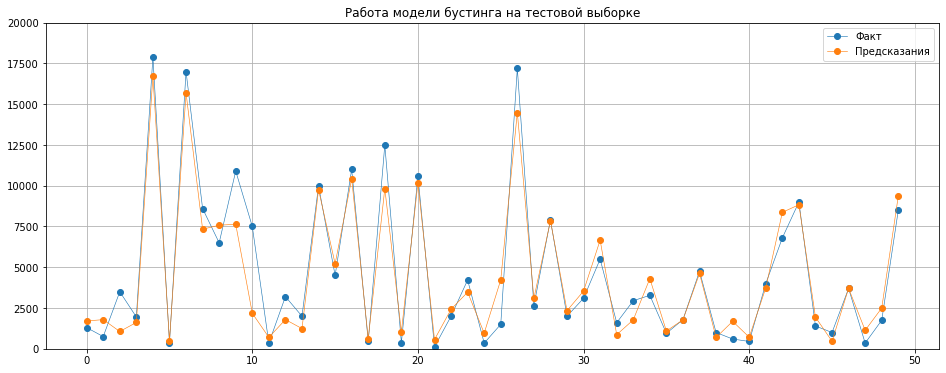

In [152]:
pd.DataFrame({'Факт': target_test,
              "Предсказания": lgbm_predict}).reset_index(drop=True).sample(50).reset_index(drop=True).plot(
    figsize=(16,6), marker='o', linestyle='-', grid=True, linewidth=0.6)
plt.ylim(0,20000)
plt.title('Работа модели бустинга на тестовой выборке')
plt.show()

Визуализируем на графике 50 случайных автомобилей из тестовой выборки: отобразим факт и предсказания модели случайного леса:

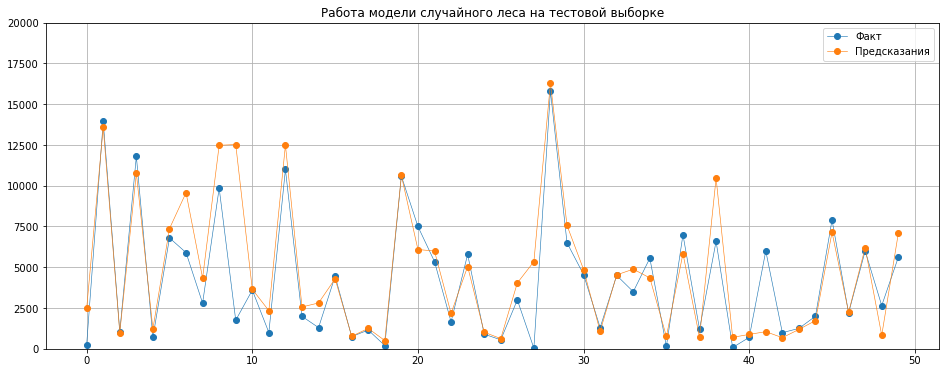

In [154]:
pd.DataFrame({'Факт': target_test,
              "Предсказания": rf_predict}).reset_index(drop=True).sample(50).reset_index(drop=True).plot(
    figsize=(16,6), marker='o', linestyle='-', grid=True, linewidth=0.6)
plt.ylim(0,20000)
plt.title('Работа модели случайного леса на тестовой выборке')
plt.show()

## 4. Общий вывод

В ходе работы были проанализированы данные о стоимости автомобилей с разными параметрами. Исходные данные содержали пропуски и артефакты, которые были обработаны. Также в ходе работы были сгенерированы дополнительные признаки, такие как возраст автомобиля и регион нахождения продавца (по почтовому индексу).

Мы построили 4 типа моделей для предсказания цены авто: 
1. Линейная регрессия
2. Дерево решений
3. Случайный лес
4. Градиентный бустинг 

Модель случайного леса и модель градиентного бустинга показали похожие результаты.
Наилучшее качество качество по параметру RMSE показала модель бустинга. Модель случайного леса показала качество чуть ниже на тесте: RMSE случайного леса = 1578 против 1567 в LightGBM. А вот величина МАЕ=946 у модели случайного леса ниже, чем в модели бустинга, где МАЕ=963. При этом в скорости предсказаний и обучения случайный лес уступает бустингу.

ТОП-3 наиболее значимых признаков:
- согласно модели бустинга: месяц регистрации, год регистрации и мощность.
- согласно модели случайного леса: мощность, возраст авто (признак, который мы сгенерировали самостоятельно) и год регистрации.

Значимые признаки, предложенные моделью случайного леса, наиболее близки к реальной практике, используемой оценщиками. С учетом относительно схожего качества моделей к реализации мы бы рекомендовали модель случайного леса за счет более реалистичных результатов.